In [24]:
from model import MAGNN_nc_mb
import pickle
from utils.data import load_PPMI_data
from utils.tools import index_generator, evaluate_results_nc, parse_minibatch

from sklearn.manifold import TSNE

from matplotlib_venn import venn2

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import data_utils as du
data_dir = du.find_data_dir('app')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [25]:
dataloader_file = du.get_file_path(data_dir, 'class based structure', 'dataloaders', 'dataloader.p')
dataloader = du.read_from_pickle(dataloader_file)
CCS = dataloader.y

In [26]:
adjlists, edge_metapath_indices_list, features_list, adjM, type_mask, labels, train_val_test_idx = load_PPMI_data()
features_list = [torch.FloatTensor(features).to(device) for features in features_list]

n_metapaths = 2
etypes_list = [[0, 1, 0], [0, 1, 1, 0]]
hidden_dim = 64
out_dim = 3
num_heads = 8
attn_vec_dim = 128
dropout_rate = 0.5
batch_size = 8
neighbor_samples = 100
rnn_type = 'RotatE0'

in_dims = [features.shape[0] for features in features_list]
in_dims[0] = features_list[0].shape[1]
for i in range(1, len(features_list)):
    dim = features_list[i].shape[0]
    indices = np.vstack((np.arange(dim), np.arange(dim)))
    indices = torch.LongTensor(indices)
    values = torch.FloatTensor(np.ones(dim))
    features_list[i] = torch.sparse.FloatTensor(indices, values, torch.Size([dim, dim])).to(device)

labels = torch.LongTensor(labels).to(device)
            
net = MAGNN_nc_mb(n_metapaths, 2, etypes_list, in_dims, hidden_dim, out_dim, num_heads, attn_vec_dim, rnn_type, dropout_rate)

train_idx = train_val_test_idx['train_idx']
train_idx = np.sort(train_idx)
test_idx = train_val_test_idx['test_idx']
test_idx = np.sort(test_idx)
val_idx = train_val_test_idx['val_idx']
val_idx = np.sort(val_idx)

net.load_state_dict(torch.load(f'checkpoint/checkpoint_PPMI.pt'))

<All keys matched successfully>

In [27]:
def evaluate_model(idx, train_val_test):
    print(f'Evaluating results for {train_val_test}')
    idx_generator = index_generator(batch_size=batch_size, indices=idx, shuffle=False)
    net.eval()
    embeddings = []
    with torch.no_grad():
        for iteration in range(idx_generator.num_iterations()):
            # forward
            idx_batch = idx_generator.next()
            g_list, indices_list, idx_batch_mapped_list = parse_minibatch(adjlists,
                                                                                         edge_metapath_indices_list,
                                                                                         idx_batch,
                                                                                         device, neighbor_samples)
            logits, embeddings_i = net((g_list, features_list, type_mask, indices_list, idx_batch_mapped_list))
            embeddings.append(embeddings_i)
        embeddings = torch.cat(embeddings, 0)
        svm_macro_f1_list, svm_micro_f1_list, nmi_mean, nmi_std, ari_mean, ari_std = evaluate_results_nc(
            embeddings.cpu().numpy(), labels[idx].cpu().numpy(), num_classes=out_dim)   
    print('')
    return embeddings

train_embeddings = evaluate_model(train_idx, 'Train')
val_embeddings = evaluate_model(val_idx, 'Val')    
test_embeddings = evaluate_model(test_idx, 'Test')    

Evaluating results for Train
SVM test
Macro-F1: 0.789494~0.066485 (0.8), 0.678464~0.083099 (0.6), 0.623801~0.083945 (0.4), 0.586112~0.056161 (0.2)
Micro-F1: 0.810526~0.048238 (0.8), 0.689189~0.081306 (0.6), 0.658182~0.060739 (0.4), 0.631507~0.055627 (0.2)
K-means test
NMI: 0.069727~0.000000
ARI: 0.028257~0.000000

Evaluating results for Val
SVM test
Macro-F1: 0.256724~0.085157 (0.8), 0.281919~0.045601 (0.6), 0.271461~0.070481 (0.4), 0.307933~0.065523 (0.2)
Micro-F1: 0.276923~0.092308 (0.8), 0.292000~0.044000 (0.6), 0.281081~0.069644 (0.4), 0.328571~0.059464 (0.2)
K-means test
NMI: 0.030169~0.000000
ARI: -0.015181~0.000000

Evaluating results for Test
SVM test
Macro-F1: 0.291064~0.149912 (0.8), 0.327660~0.046263 (0.6), 0.305278~0.043422 (0.4), 0.320794~0.086408 (0.2)
Micro-F1: 0.321429~0.143747 (0.8), 0.366667~0.056047 (0.6), 0.337500~0.040697 (0.4), 0.347170~0.076502 (0.2)
K-means test
NMI: 0.011576~0.000000
ARI: -0.002515~0.000000



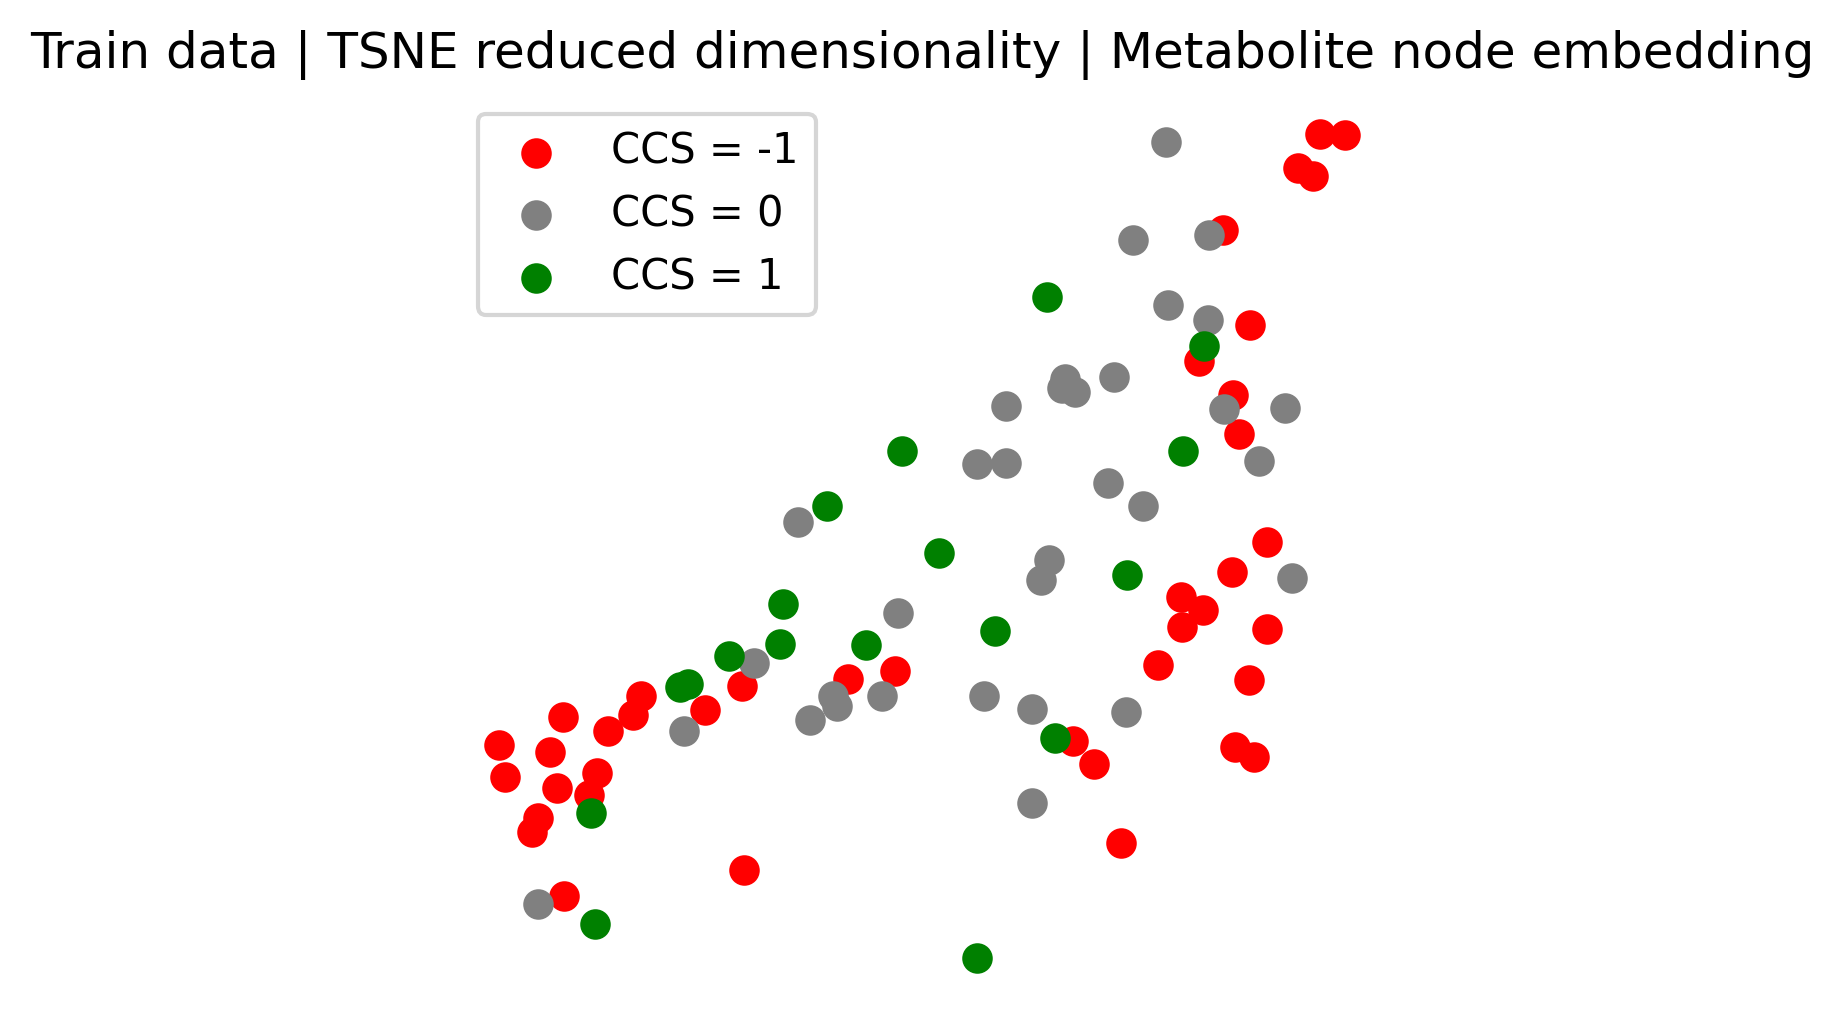

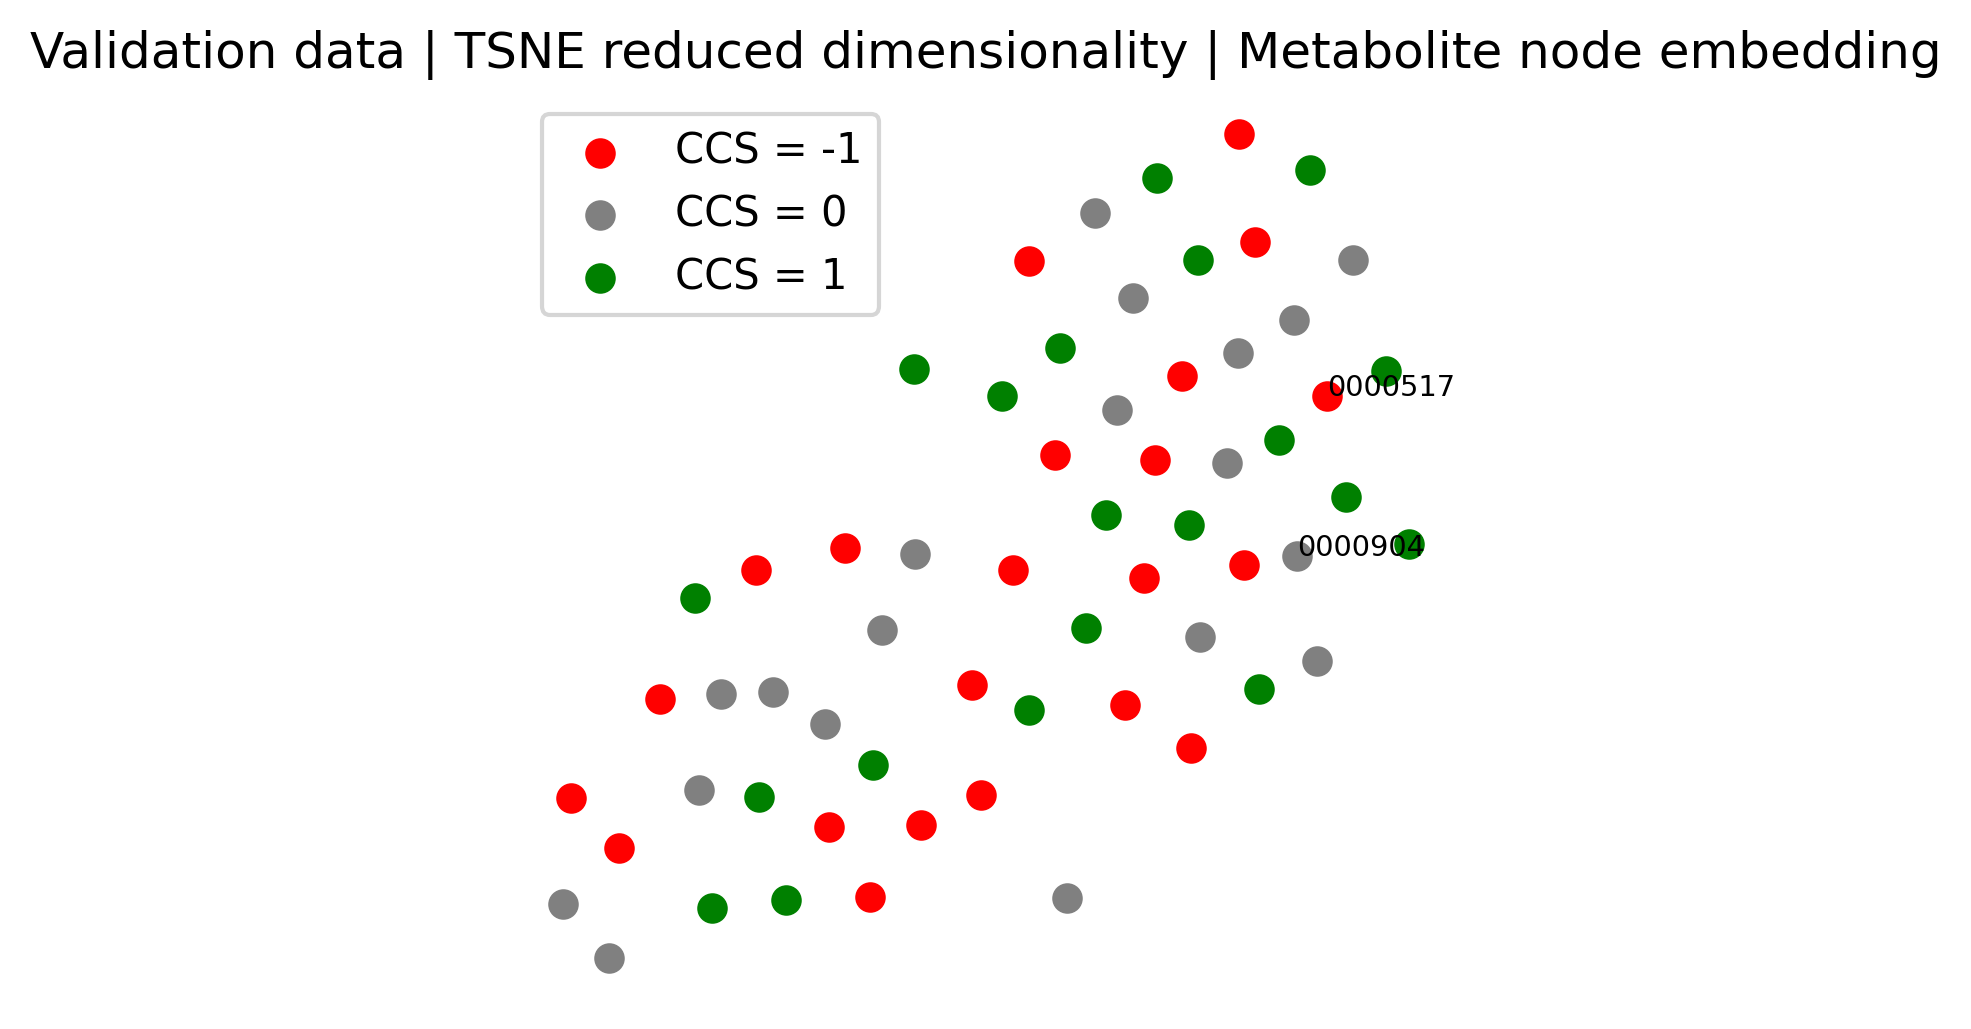

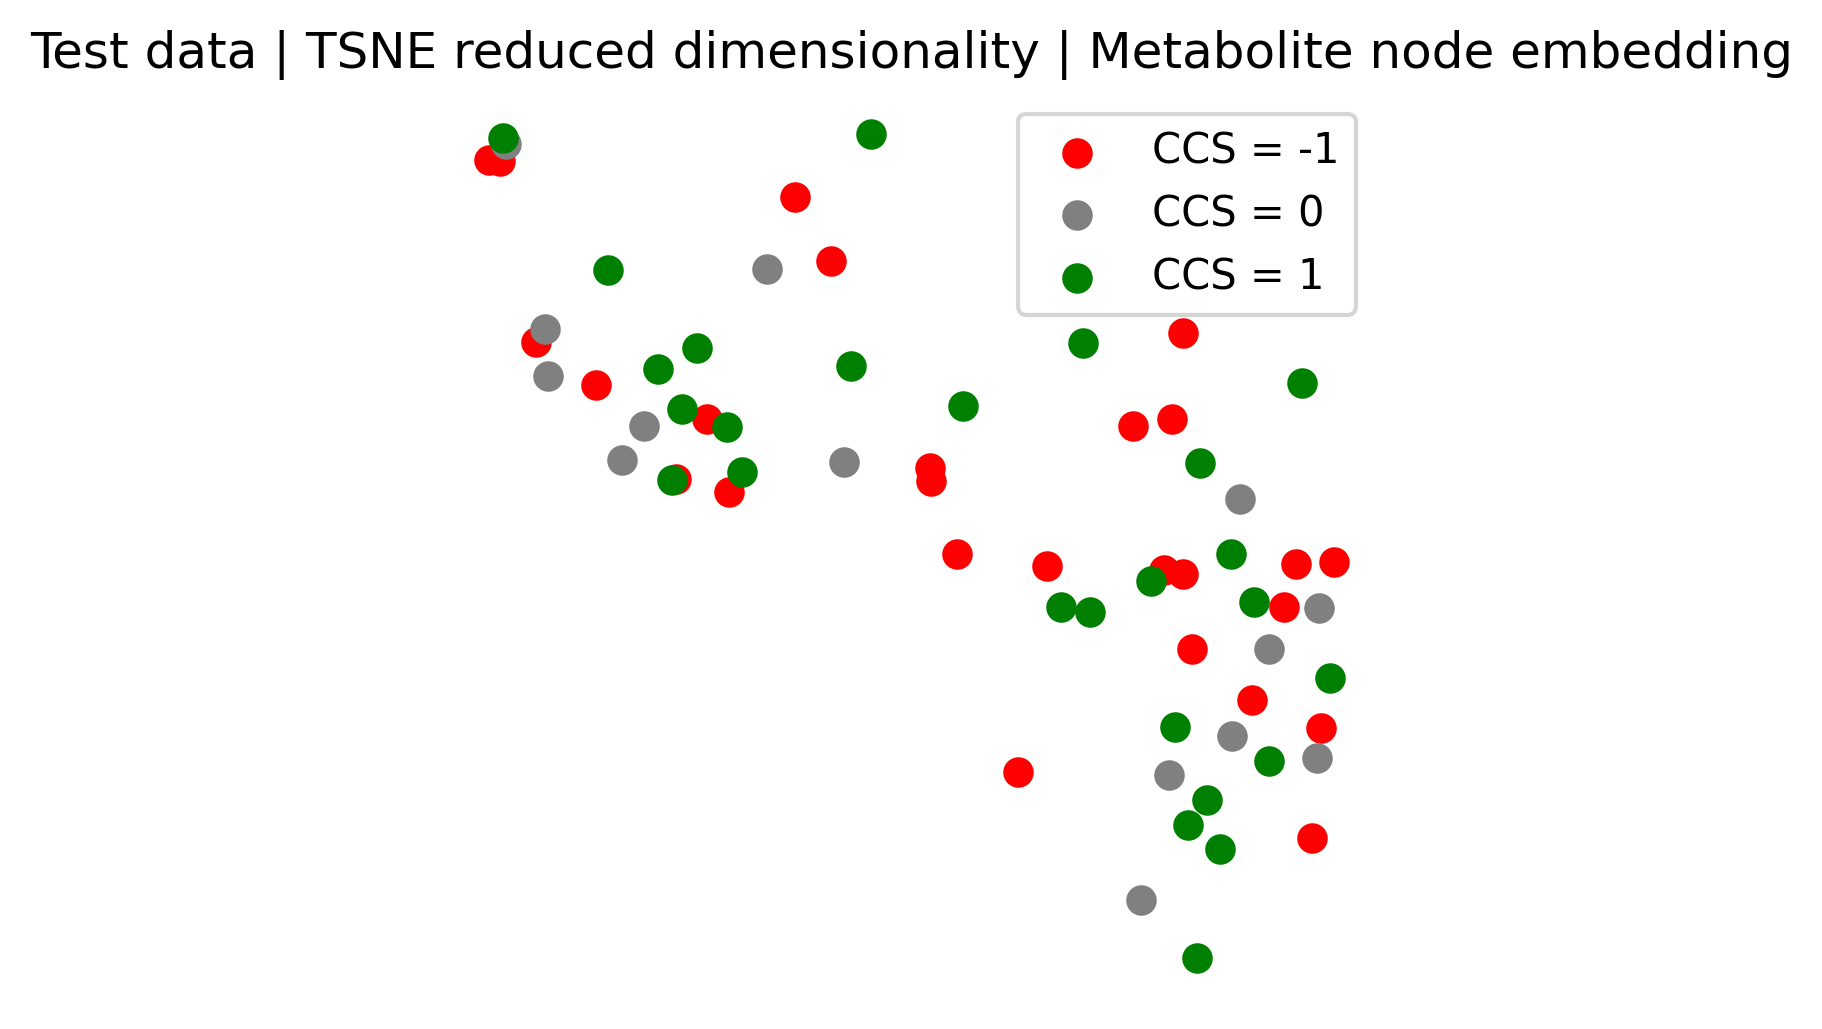

In [28]:
def plot_embedding(embeddings, labels, idx, train_test, method='TSNE', plot_labels=False, CCS=None, highlighted=[]):
    if method=='PCA':
        embedding_2d = torch.pca_lowrank(embeddings, 2)[0]
    elif method=='TSNE':
        embedding_2d = TSNE(n_components=2).fit_transform(embeddings)
    else:
        pass
    
    metabolite_down_mask = np.argwhere(labels[idx]==0)
    metabolite_equal_mask = np.argwhere(labels[idx]==1.)
    metabolite_up_mask = np.argwhere(labels[idx]==2.)

    X_down = embedding_2d[:, 0][metabolite_down_mask][0]
    Y_down = embedding_2d[:, 1][metabolite_down_mask][0]

    X_equal = embedding_2d[:, 0][metabolite_equal_mask][0]
    Y_equal = embedding_2d[:, 1][metabolite_equal_mask][0]
    
    X_up = embedding_2d[:, 0][metabolite_up_mask][0]
    Y_up = embedding_2d[:, 1][metabolite_up_mask][0]
    
    plt.figure(figsize=(4,4), dpi=300)
    
    size = 40
    
    plt.scatter(X_down, Y_down, s=size, c='red', label='CCS = -1')
    plt.scatter(X_equal, Y_equal, s=size, c='gray', label='CCS = 0')
    plt.scatter(X_up, Y_up, s=size, c='green', label='CCS = 1')
    
    if plot_labels:
        fontsize='x-small'
        xy_idx_list_down = list(zip(X_down, Y_down, idx[metabolite_down_mask][0]))
        for x, y, i in xy_idx_list_down:
            if len(highlighted)==0 or (len(highlighted) > 0 and CCS.index[i] in highlighted):
                plt.text(x, y, CCS.index[i][4:], fontsize=fontsize)

        xy_idx_list_equal = list(zip(X_equal, Y_equal, idx[metabolite_equal_mask][0]))
        for x, y, i in xy_idx_list_equal:
            if len(highlighted)==0 or (len(highlighted) > 0 and CCS.index[i] in highlighted):
                plt.text(x, y, CCS.index[i][4:], fontsize=fontsize)
            
        xy_idx_list_up = list(zip(X_up, Y_up, idx[metabolite_up_mask][0]))
        for x, y, i in xy_idx_list_up:
            if len(highlighted)==0 or (len(highlighted) > 0 and CCS.index[i] in highlighted):
                plt.text(x, y, CCS.index[i][4:], fontsize=fontsize)
    
    plt.legend()
    
    plt.title(f'{train_test} data | {method} reduced dimensionality | Metabolite node embedding')
    plt.axis('off')
    plt.show()   
    return embedding_2d, metabolite_down_mask, idx

highlighted = ['HMDB0000517', 'HMDB0000904']
# highlighted=[]

res = plot_embedding(train_embeddings, labels, train_idx, 'Train', method='TSNE', plot_labels=True, CCS=CCS, highlighted=highlighted)
res = plot_embedding(val_embeddings, labels, val_idx, 'Validation', method='TSNE', plot_labels=True, CCS=CCS, highlighted=highlighted)
res = plot_embedding(test_embeddings, labels, test_idx, 'Test', method='TSNE', plot_labels=True, CCS=CCS, highlighted=highlighted)

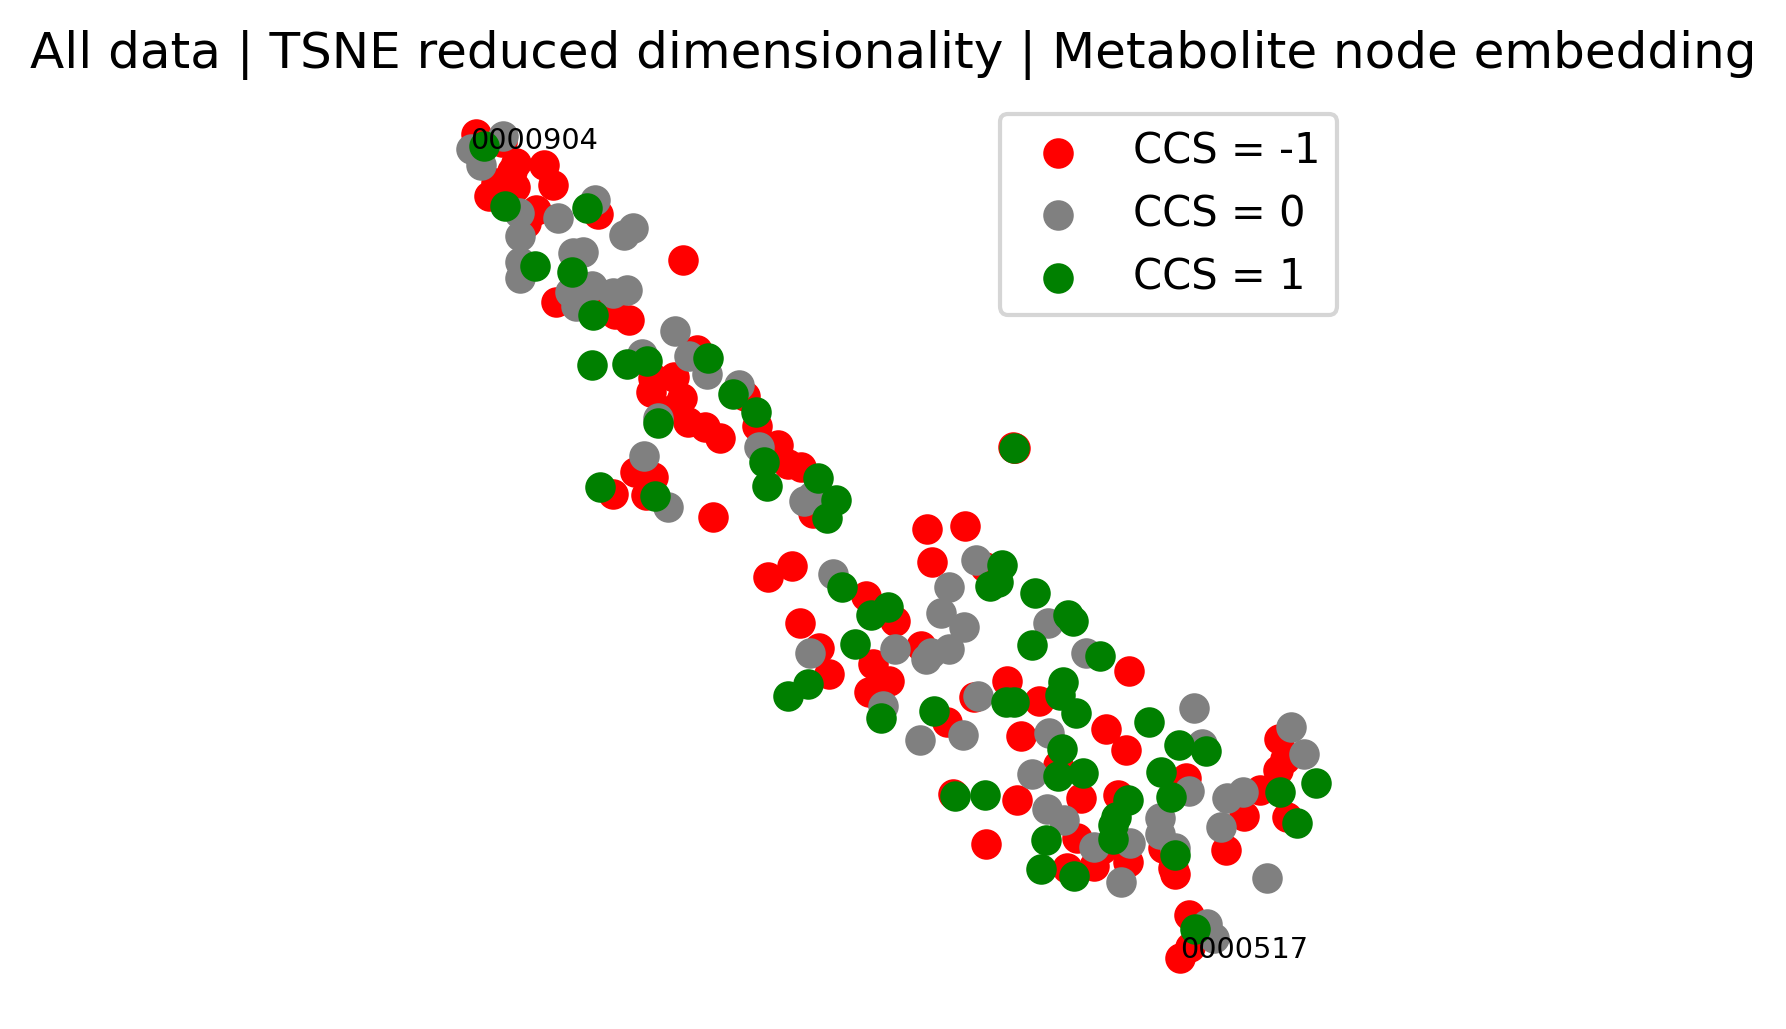

In [29]:
all_embeddings = torch.cat((train_embeddings, val_embeddings, test_embeddings))
res = plot_embedding(all_embeddings, labels, np.arange(all_embeddings.shape[0]), 'All', method='TSNE', plot_labels=True, CCS=CCS, highlighted=highlighted)

### Creating Venn diagrams

hmdb_accession
HMDB0000214    24
HMDB0000052    21
HMDB0001049     5
HMDB0000286     5
HMDB0000968     4
HMDB0004195     3
HMDB0001248     3
HMDB0000099     3
HMDB0001185     3
HMDB0000217     3
Name: HMDB0000904_metapath_0_based_neighbours, dtype: int64 



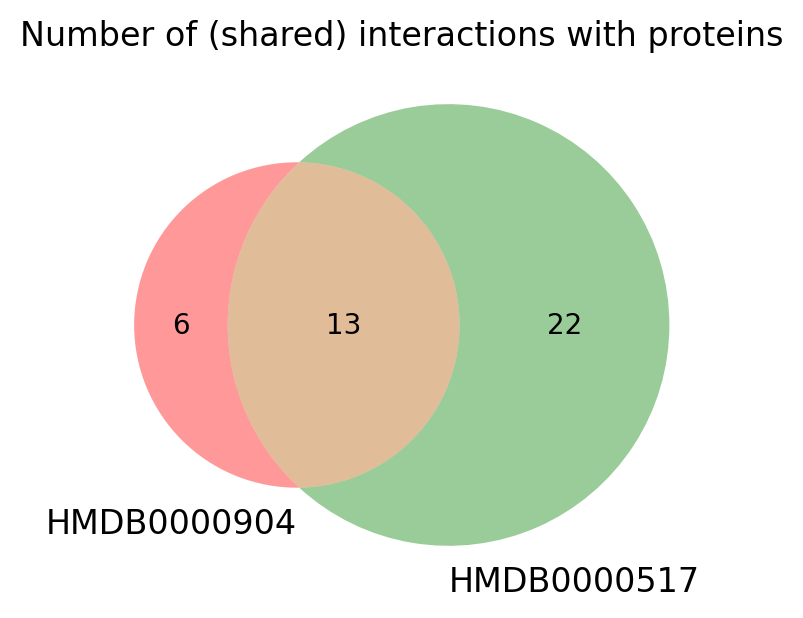

In [30]:
def plot_venn_protein_links(metabolite_A, metabolite_B):
    set_a = set(list(dataloader.PPMI_pruned[metabolite_A]))
    set_b = set(list(dataloader.PPMI_pruned[metabolite_B]))

    # Second way
    fig = plt.figure(figsize=(4,4), dpi=200)
    fig.patch.set_facecolor('white')    
    v = venn2([set_a, set_b], set_labels = (metabolite_A, metabolite_B))
    plt.title('Number of (shared) interactions with proteins')
    plt.show()

def get_matapath_based_neighbors(target_node_name, metapath_index=0):
    target_node_index = list(CCS.index).index(target_node_name)
    metapaths_inspect = edge_metapath_indices_list[metapath_index][target_node_index]
    metapath_based_neighbors = pd.Series(metapaths_inspect[:, 0]).value_counts()
    metapath_based_neighbors.index = CCS.index[np.array(metapath_based_neighbors.index)]
    name = f'{CCS.index[target_node_index]}_metapath_{metapath_index}_based_neighbours'
    metapath_based_neighbors.name = name
    return metapath_based_neighbors

get_matapath_based_neighbors('HMDB0000904')
print(get_matapath_based_neighbors('HMDB0000904')[:10], '\n')
plot_venn_protein_links('HMDB0000904', 'HMDB0000517')

### Investigating feature value distributions

In [31]:
def create_feature_distribution_df(dataloader, feature_name):
    target_distribution_stats = dataloader.target_distribution_stats()
    df = pd.DataFrame(pd.DataFrame([dataloader.X[feature_name], dataloader.y]).T.value_counts(), columns=['CCS_value_amount']).reset_index()
    df2 = df.loc[:,[feature_name, 'CCS_value_amount']]
    df2 = df2.set_index(feature_name)
    df3 = df2.groupby(df2.index).sum()
    df['feature_value_amount'] = df3['CCS_value_amount'][df[feature_name]].reset_index(drop=True)
    df['value_percentage'] = df['CCS_value_amount'] / df['feature_value_amount'] * 100
    df['original_percentage'] = target_distribution_stats.data.loc[df['CCS']]['Percentage'].reset_index(drop=True)
    df = df.sort_values([feature_name, 'CCS'], ascending=False)
    df['diff_percentage'] = df['value_percentage'] - df['original_percentage']
    df = df.reset_index(drop=True)
    df = df.set_index([feature_name, 'CCS'])
    # cols_to_move = [feature_name, 'feature_value_amount']
    # df           = df[ cols_to_move + [ col for col in df.columns if col not in cols_to_move ] ]
    return df.style.format({"value_percentage": "{:.1f}%", "original_percentage": "{:.1f}%",  "diff_percentage": "{:.1f}%"})

# display(create_feature_distribution_df(dataloader, 'state=="Solid"'))
        
for feature_name in list(dataloader.X.columns)[2:]:
    display(create_feature_distribution_df(dataloader, feature_name))

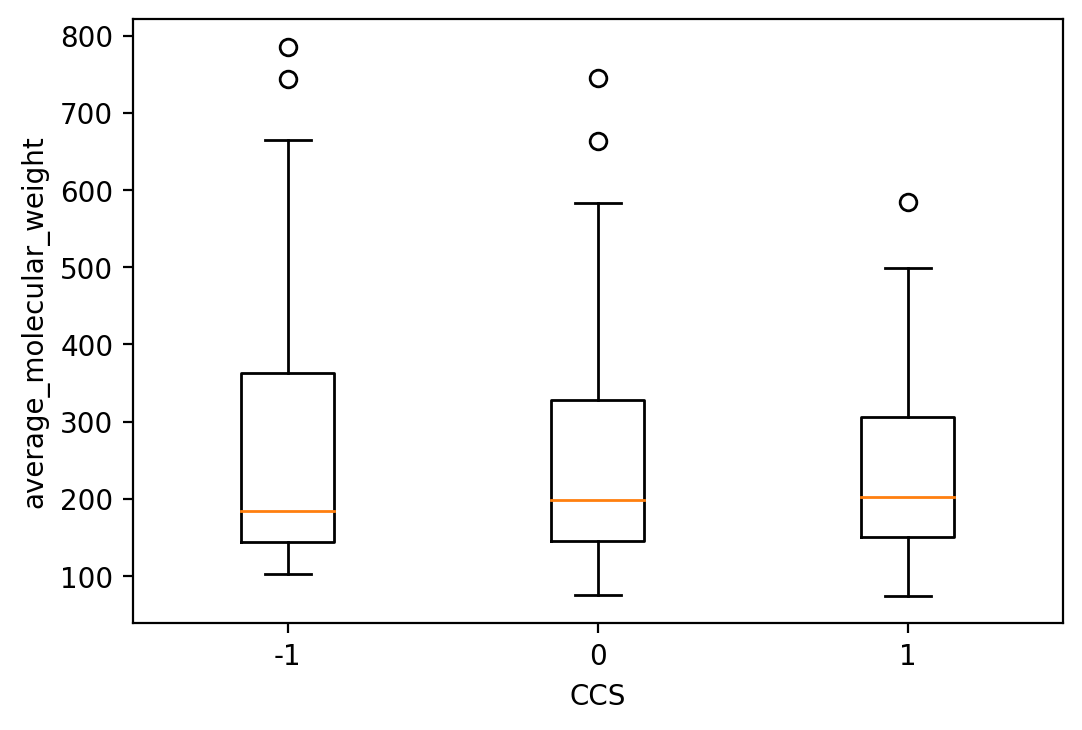

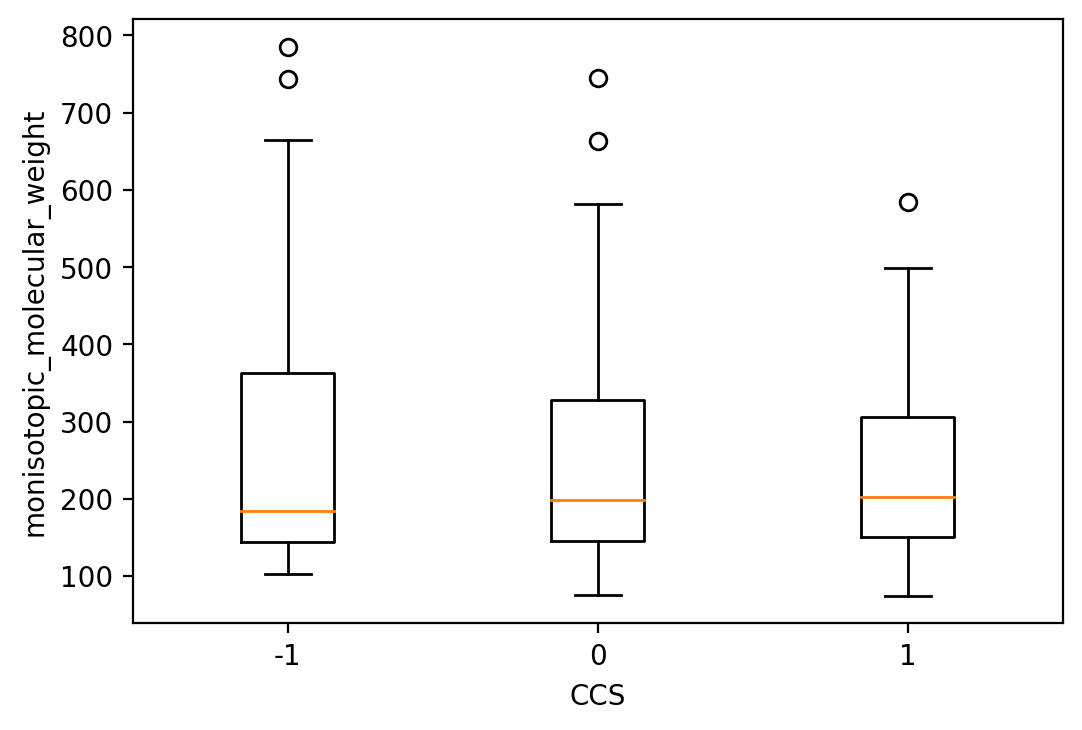

In [332]:
def boxplot_CCS_values(dataloader, feature_name):
    metabolite_down_mask = np.argwhere(labels==0)
    metabolite_equal_mask = np.argwhere(labels==1.)
    metabolite_up_mask = np.argwhere(labels==2.)

    amw = dataloader.X[feature_name]

    fig = plt.figure(figsize=(6,4), dpi=200)
    plt.boxplot([np.array(amw)[metabolite_down_mask][0], np.array(amw)[metabolite_equal_mask][0], np.array(amw)[metabolite_up_mask][0]], labels=[-1, 0, 1])
    plt.xlabel('CCS')
    plt.ylabel(feature_name)
    plt.show()
    
boxplot_CCS_values(dataloader,  'average_molecular_weight')
boxplot_CCS_values(dataloader,  'monisotopic_molecular_weight')

### Writing results to PDF for discussion

Todo: styling numbers

Multiple df in one pdf

Write text to show which variable

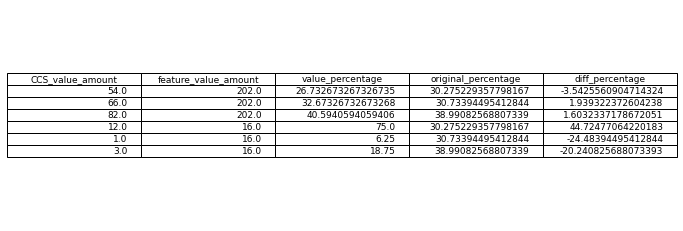

In [23]:
from matplotlib.backends.backend_pdf import PdfPages

df = create_feature_distribution_df(dataloader, 'state=="Solid"').data

#https://stackoverflow.com/questions/32137396/how-do-i-plot-only-a-table-in-matplotlib
fig, ax =plt.subplots(figsize=(12,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df.values,colLabels=df.columns,loc='center')

#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
#https://stackoverflow.com/questions/38686926/write-multiple-dataframes-to-same-pdf-file-using-matplotlib
pp = PdfPages('Sample.pdf')
pp.savefig(fig, bbox_inches='tight')
pp.close()

### Experimentation

In [98]:
features_list[0].shape

torch.Size([218, 445])

In [13]:
train_embeddings.shape
val_embeddings.shape
test_embeddings.shape

torch.Size([66, 512])

In [39]:
CCS.index[1], CCS.index[0]

('HMDB0000517', 'HMDB0000161')

In [114]:
list(CCS.index).index('HMDB0000904')

96

In [59]:
dataloader.PPMI_pruned['HNRNPU']
dataloader.PPMI_pruned['KYNU']

AtlasView({'HMDB0000161': {}, 'RPS6KA1': {}, 'LDHAL6B': {}, 'ADSS': {}, 'NDRG1': {}, 'ASNS': {}, 'NUP210': {}, 'NAGK': {}, 'SEC23IP': {}, 'PPM1G': {}, 'MVD': {}, 'SSU72': {}, 'LYN': {}, 'PEPD': {}, 'SMS': {}, 'CSE1L': {}, 'PALM2': {}, 'SMARCD2': {}, 'BCCIP': {}, 'SGTA': {}, 'GNS': {}, 'C11ORF58': {}, 'LDHA': {}, 'TPM3': {}, 'CNDP2': {}, 'UBC': {}, 'CHORDC1': {}, 'GDA': {}, 'COIL': {}, 'SIRT1': {}, 'SMEK2': {}, 'GSR': {}, 'HMDB0000902': {}, 'HMDB0000684': {}})

In [161]:
target_distribution_stats = dataloader.target_distribution_stats()
target_distribution_stats

,Amount,Percentage
-1,85,39.0%
0,67,30.7%
1,66,30.3%
Total,218,100.0%


In [136]:
list(dataloader.X.loc['HMDB0000904'].index)
dataloader.X.loc['HMDB0000904'][dataloader.X.loc['HMDB0000904']==1.]

state=="Solid"                                          1.0
kingdom=="Organic compounds"                            1.0
super_class=="Organic acids and derivatives"            1.0
class=="Carboxylic acids and derivatives"               1.0
molecular_framework=="Aliphatic acyclic compounds"      1.0
"Mitochondria" in cellular_locations                    1.0
"Blood" in biospecimen_locations                        1.0
"Feces" in biospecimen_locations                        1.0
"Urine" in biospecimen_locations                        1.0
"Saliva" in biospecimen_locations                       1.0
"Cerebrospinal Fluid (CSF)" in biospecimen_locations    1.0
"Sweat" in biospecimen_locations                        1.0
"Fibroblasts" in tissue_locations                       1.0
"Neuron" in tissue_locations                            1.0
"Kidney" in tissue_locations                            1.0
"Placenta" in tissue_locations                          1.0
"Liver" in tissue_locations             

In [138]:
dataloader.X[dataloader.X['class=="Carboxylic acids and derivatives"']==1.]

,average_molecular_weight,monisotopic_molecular_weight,"state==""Solid""","state==""Liquid""","state==""Gas""","state==""nan""","kingdom==""Organic compounds""","kingdom==""Inorganic compounds""","kingdom==""None""","super_class==""Organic acids and derivatives""",...,"""Hair"" in tissue_locations","""Testes"" in tissue_locations","""Adrenal Medulla"" in tissue_locations","""Smooth Muscle"" in tissue_locations","""Epidermis"" in tissue_locations","""Retina"" in tissue_locations","""Basal Ganglia"" in tissue_locations","""Gall Bladder"" in tissue_locations","""Spleen"" in tissue_locations","""Bladder"" in tissue_locations"
hmdb_accession,,,,,,,,,,,,,,,,,,,,,
HMDB0000161,89.0932,89.047678,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
HMDB0000517,174.2010,174.111676,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,1
HMDB0000168,132.1179,132.053492,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
HMDB0000191,133.1027,133.037508,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
HMDB0000574,121.1580,121.019749,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HMDB0001229,195.1721,195.053158,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
HMDB0000021,307.0851,306.970537,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
HMDB0000265,650.9735,650.790038,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [30]:
dataloader.X.loc['HMDB0000292'].compare(dataloader.X.loc['HMDB0001185'], keep_equal=True)

,self,other
average_molecular_weight,152.110900,399.445000
monisotopic_molecular_weight,152.033425,399.145064
"super_class==""Nucleosides, nucleotides, and analogues""",0.000000,1.000000
"super_class==""Organoheterocyclic compounds""",1.000000,0.000000
"class==""Imidazopyrimidines""",1.000000,0.000000
"class==""5'-deoxyribonucleosides""",0.000000,1.000000
"""Carboxylic acids"" in alternative_parents",0.000000,1.000000
"""1,2-diols"" in alternative_parents",0.000000,1.000000
"""Pentoses"" in alternative_parents",0.000000,1.000000
"""Amino acids"" in alternative_parents",0.000000,1.000000


In [71]:
dataloader.X.loc['HMDB0000902']

average_molecular_weight               663.425100
monisotopic_molecular_weight           663.109122
state=="Solid"                           1.000000
state=="Liquid"                          0.000000
state=="Gas"                             0.000000
                                          ...    
"Retina" in tissue_locations             0.000000
"Basal Ganglia" in tissue_locations      0.000000
"Gall Bladder" in tissue_locations       0.000000
"Spleen" in tissue_locations             0.000000
"Bladder" in tissue_locations            0.000000
Name: HMDB0000902, Length: 1989, dtype: Sparse[float64, 0]

In [72]:
dataloader.y['HMDB0000902']

0

In [74]:
val_idx

array([  0,   1,  12,  28,  29,  30,  32,  39,  46,  54,  55,  56,  59,
        63,  66,  68,  69,  70,  75,  78,  81,  85,  86,  93,  94,  95,
       101, 103, 105, 110, 111, 122, 128, 132, 133, 134, 137, 144, 150,
       155, 159, 160, 163, 164, 165, 167, 171, 178, 182, 188, 191, 192,
       196, 197, 200, 203, 205, 210, 211, 214, 215])